In [1]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import os

# Wybierz 10 klas

Poniżej przygotuj listę 10 klas z:
https://quickdraw.withgoogle.com/data

> nazwy takie jak nazwy obiektów (wyświetlane po najechaniu lub kliknięciu)

In [2]:
class_names=["butterfly","camel","bee","cow","crab","horse","octopus","penguin","rabbit","raccoon"]
#class_names = ["book","airplane","circle","owl","sun","whale","tooth","panda","onion","parrot"]

## Test

In [3]:
assert len(class_names)==10, 'Nazw powinno być dokładnie 10'
for i in range(len(class_names)):
    assert type(class_names[i])==str, 'Każda z nazw powinna być typu str'
    assert '/' not in class_names[i], 'Same nazwy klas, ze spacjami, bez ukośników'

# Wczytanie danych
Pobieranie plików z obrazami w formaci npy (numpy)

In [4]:
for name in class_names:
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%name
    file_name = url.split('/')[-1].split('?')[0]
    if os.path.isdir('D:\Datasety do kursu ML\QuickDraw\\'):
        file_name = "D:\Datasety do kursu ML\QuickDraw\\"+file_name
    url = url.replace(' ','%20')
    
    if not os.path.isfile(file_name):
        print(url, '==>', file_name)
        urllib.request.urlretrieve(url, file_name)

## Wczytywanie z plików .npy
Dane znajdziesz w tablicy data

In [5]:
data = []
for name in class_names:
    file_name = "D:\Datasety do kursu ML\QuickDraw\\"+name+'.npy'
    data.append(np.load(file_name, fix_imports=True, allow_pickle=True))
    print('%-15s'%name,type(data[-1]))

butterfly       <class 'numpy.ndarray'>
camel           <class 'numpy.ndarray'>
bee             <class 'numpy.ndarray'>
cow             <class 'numpy.ndarray'>
crab            <class 'numpy.ndarray'>
horse           <class 'numpy.ndarray'>
octopus         <class 'numpy.ndarray'>
penguin         <class 'numpy.ndarray'>
rabbit          <class 'numpy.ndarray'>
raccoon         <class 'numpy.ndarray'>


# Liczebności i wymiary zdjęć
Wypisz nazwę i shape dla każdej klasy

In [6]:
for i,name in enumerate(class_names):
    print('%-15s'%name,data[i].shape)

butterfly       (117999, 784)
camel           (121399, 784)
bee             (120890, 784)
cow             (123083, 784)
crab            (126930, 784)
horse           (178286, 784)
octopus         (150152, 784)
penguin         (253791, 784)
rabbit          (155288, 784)
raccoon         (119588, 784)


Poniżej zwizualizuj liczbę zdjęć per klasę:

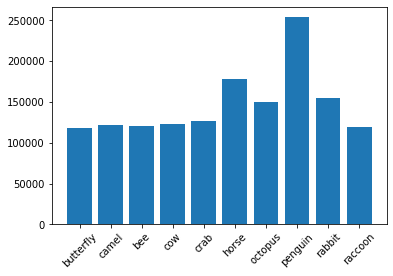

In [7]:
count_photo = {}
for i,name in enumerate(class_names):
    count_photo[name] = len(data[i])

plt.bar(x=count_photo.keys(),height=count_photo.values())
plt.xticks(rotation=45);

# Wizualizacja danych
Dane są w macierzach dwuwyamirowych,
aby je poprawnie wyświetlić jako obraz,
należy je przekonwertować do 3 wymiarów:

- numer zdjęcia
- wysokość
- szerokość

Tu pomoże `reshape` z numpy.

## Konwersja do (-1, 28, 28)

In [8]:
new_data = []
for num_class,_ in enumerate(count_photo.values()):
    new_data.append(np.reshape(data[num_class],(-1,28,28)))

Wyświetl po jednym przykładzie z każdej klasy.

Możesz skorzystać z `plt.subplot`

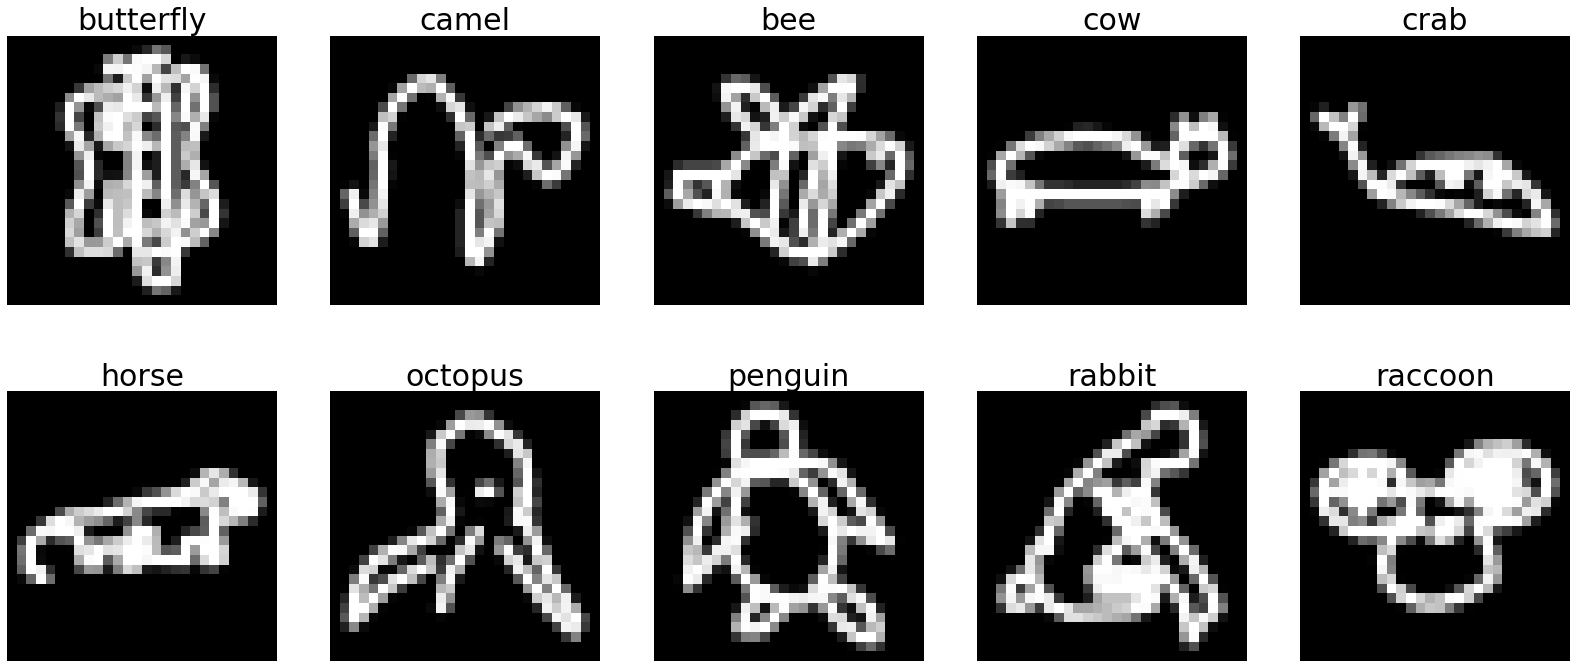

In [9]:
for i,_ in enumerate(new_data):
    np.random.shuffle(new_data[i])

plt.figure(figsize=(28,12))
for i, example in enumerate(new_data):
    plt.subplot(2,5,i+1)
    plt.title(class_names[i], fontsize=30)
    plt.imshow(example[i], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

## Obraz średni
Jak podobne do siebie są obrazy z poszczególnych klas?

Oblicz i wyświetl średni obraz dla wszystkich klas.

Możesz skorzystać z `np.mean`

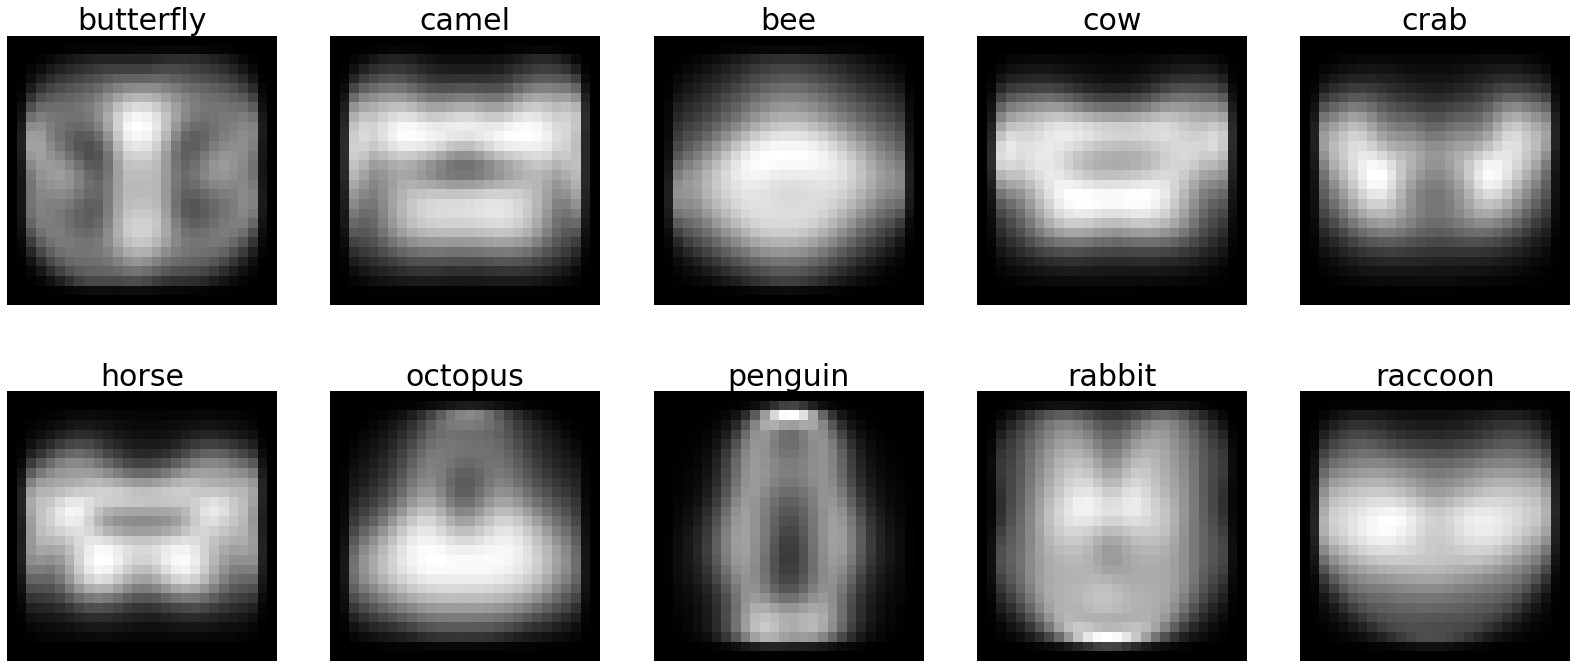

In [10]:
plt.figure(figsize=(28,12))
for i,class_element in enumerate(new_data):
    plt.subplot(2,5,i+1)
    plt.title(class_names[i], fontsize=30)
    plt.imshow(np.mean(class_element,axis=0), cmap='gray')
    plt.axis('off')

In [11]:
import seaborn as sns
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

sns.set(style='whitegrid', font_scale=1.5)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc = nn.Linear(15488, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [13]:
torch.cuda.is_available()

True

In [14]:
X = np.concatenate(data,axis=0)
X = np.array([_.reshape(28,28,1) for _ in X])
y = np.concatenate([[counter] * data[counter].shape[0] for counter, value in enumerate(data)],axis=0)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device_cpu = torch.device("cpu")
torch.cuda.empty_cache()
print(use_cuda,device)

epochs=10
batch_size=64

transform=transforms.Compose([
    transforms.ToTensor(),
    ])


X_train =torch.from_numpy(X_train).half().to(device)
X_val = torch.from_numpy(X_val).half().to(device)
y_val= torch.from_numpy(y_val).type(torch.int8).to(device)
y_train= torch.from_numpy(y_train).type(torch.int8).to(device)

X_train = X_train.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)


train_set =  TensorDataset(X_train, y_train)
val_set =  TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

True cuda


In [17]:
torch.cuda.empty_cache()

In [21]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters())

train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]

for epoch in range(1, epochs + 1):
    model.train()
    train_loss=0
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(device), target.type(torch.int64).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().detach() # instead of item -> https://pytorch-lightning.readthedocs.io/en/latest/guides/speed.html#things-to-avoid
        train_loss+=loss.detach()
    train_loss/=len(train_loader)
    acc = correct / float(len(train_loader.dataset))
    train_losses.append(train_loss)
    train_accs.append(acc)
    
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.float().to(device), target.type(torch.int64).to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').detach()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().detach()
        

    val_loss /= len(val_loader.dataset)
    val_acc = correct / float(len(val_loader.dataset))
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print("Epoch %3d Train loss: %f Acc: %f Val   loss: %f Acc: %f"%(epoch, train_loss, acc, val_loss, val_acc))

Epoch   1 Train loss: 0.518528 Acc: 0.840882 Val   loss: 0.432187 Acc: 0.863889
Epoch   2 Train loss: 0.414141 Acc: 0.871087 Val   loss: 0.408579 Acc: 0.872033
Epoch   3 Train loss: 0.394032 Acc: 0.877271 Val   loss: 0.409400 Acc: 0.874824
Epoch   4 Train loss: 0.383173 Acc: 0.880800 Val   loss: 0.394277 Acc: 0.877798
Epoch   5 Train loss: 0.374074 Acc: 0.883759 Val   loss: 0.388511 Acc: 0.878892
Epoch   6 Train loss: 0.368884 Acc: 0.885342 Val   loss: 0.393940 Acc: 0.878013
Epoch   7 Train loss: 0.364003 Acc: 0.886777 Val   loss: 0.399342 Acc: 0.875526
Epoch   8 Train loss: 0.363180 Acc: 0.886820 Val   loss: 0.402742 Acc: 0.878711
Epoch   9 Train loss: 0.360288 Acc: 0.887583 Val   loss: 0.392543 Acc: 0.879011
Epoch  10 Train loss: 0.358452 Acc: 0.888263 Val   loss: 0.403525 Acc: 0.876054


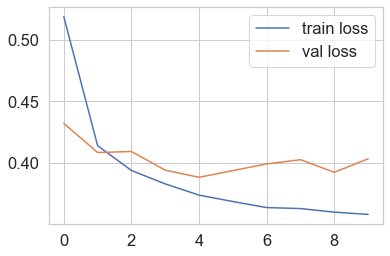

In [22]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend();


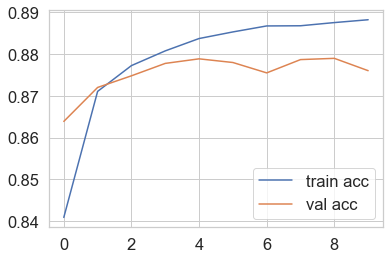

In [23]:
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend();

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.